# `Промышленное машинное обучение на Spark`
## `Занятие 07: Spark Recomendation Systems. ALS.`

О чём можно узнать из этого ноутбука:

* Построение рекомендательной системы для фильмов
* Алгоритм ALS в Pyspark
* Настройка выбор оптимальных гиперпараметров для ALS модели

In [1]:
! pip3 install pyspark pyarrow seaborn 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys
import urllib
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt


import pyspark.sql.functions as F

from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

%matplotlib inline

In [3]:
conf = (
    SparkConf()
        .set('spark.ui.port', '4050')
        .set('spark.driver.memory', '4g')
        .set('spark.executor.extraJavaOptions', '-Xss512m')
        .set('spark.driver.extraJavaOptions', '-Xss512m')
        .setMaster('local[*]')
)
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

23/11/25 01:17:26 WARN Utils: Your hostname, vm-01 resolves to a loopback address: 127.0.1.1; using 10.128.0.16 instead (on interface eth0)
23/11/25 01:17:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/25 01:17:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### `Загрузка данных`

Загрузим и распакуем данные с официального источника. Для экспериментов возьмём самый маленький датасет, в котором содержаться 100тыс оценок от 1000 пользователей по 1700 фильмам

In [4]:
file_url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

archive_filename = "movielens-100k.zip"
urllib.request.urlretrieve(file_url, archive_filename)

path = "movielens-100k"
with zipfile.ZipFile(archive_filename, 'r') as zip_ref:
    zip_ref.extractall(path)

os.remove(archive_filename)

Информация о поставленных оценках содержиться в файле u.data. Прочитаем и загрузим его в Spark

In [5]:
# Зададим пути к файлам из датасета
data_file = f"{path}/ml-100k/u.data"

file_type = "csv"
infer_schema = "false"
first_row_is_header = "false"
delimiter = "\t"

schema = StructType(
    (
        StructField("UserId", IntegerType()),
        StructField("MovieId", IntegerType()),
        StructField("Rating", FloatType()),
        StructField("Timestamp", LongType()),
    )
)

ratings_df = (
    spark.read.csv(data_file, schema=schema, sep="\t", header=False)
)

In [6]:
# посмотрим на данные
ratings_df.show(10)

+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
+------+-------+------+---------+
only showing top 10 rows



In [7]:
ratings_df.printSchema()

root
 |-- UserId: integer (nullable = true)
 |-- MovieId: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Timestamp: long (nullable = true)



### `Исследование и визуализация данных`

Посмотрим на распределение оценок в данном датасете

   Rating  count
0     5.0  21201
1     2.0  11370
2     3.0  27145
3     1.0   6110
4     4.0  34174


<Axes: xlabel='Rating', ylabel='count'>

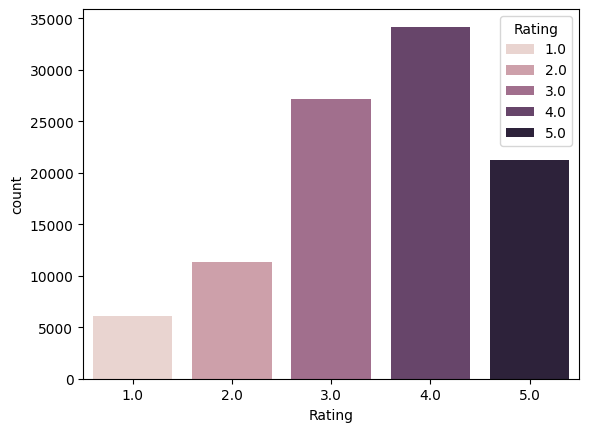

In [8]:
ratings_stat = ratings_df.groupby("Rating").count().toPandas()
print(ratings_stat)
sns.barplot(ratings_stat, x="Rating", y="count", hue="Rating")

Теперь посмотрим, как часто оценивается тот или иной фильм

<Axes: xlabel='count', ylabel='Count'>

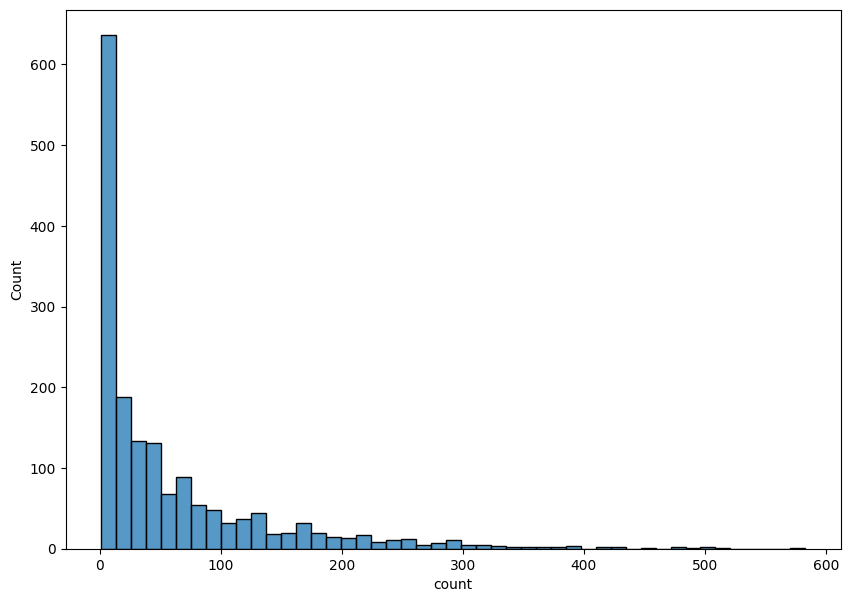

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

count_marks_stat = ratings_df.groupby("MovieId").count().toPandas()
sns.histplot(count_marks_stat, x="count", ax=ax)

### `Обучение модели`

Поделим датасет на данные для обучения и теста в пропорции 7 к 3

In [10]:
ratings_df = ratings_df.sample(fraction=0.5)
train_ratings_df, test_ratings_df = ratings_df.randomSplit([0.7, 0.3], seed=123)
train_ratings_df, test_ratings_df = train_ratings_df.cache(), test_ratings_df.cache()
# Выведем сколько данных попало в обучение, а сколько на тест
train_ratings_df.count(), test_ratings_df.count()

(34892, 15110)

Pyspark предоставляет уже готовый алгоритм ASL из пакета pysprk.recommendation. Поэтому создадим объект для данной модели и проинициализируем его гиперпараметры какими-нибудь значениями, которые потом доуточним на кросс-валидации

In [11]:
als = ALS(
    rank=10, # размерность признакового пространства
    maxIter=15, # количество итераций в алгоритме решения
    regParam=0.05, # параметр регуляризации lambda: Err + lambda(||u|| + ||i||)
    coldStartStrategy='drop', # Стратегия холодного старта, не делаем предскзаний
                              # для тех пользователей, которых не было в обучении
    userCol="UserId", # название колонки с id пользователя
    itemCol="MovieId", # название колонки с id предмета
    ratingCol="Rating" # название колонки с оценкой
)

In [12]:
print(als.explainParams())

alpha: alpha for implicit preference (default: 1.0)
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
coldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)
finalStorageLevel: StorageLevel for ALS model factors. (default: MEMORY_AND_DISK)
implicitPrefs: whether to use implicit preference (default: False)
intermediateStorageLevel: StorageLe

Обучим модель на обучающем множестве

In [13]:
trained_model = als.fit(train_ratings_df)

23/11/25 01:17:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS                                                                           
23/11/25 01:17:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Теперь сделаем предсказания для всех фильмов и всех пользователей, которые попали в обучающее множество. При этом не забудем удалить те ячейки, у которых уже стоят изначально оценки, поскольку нас интересуют предсказания на непросмотренных пользователем фильмах. 

In [14]:
users = train_ratings_df.select("UserId").distinct() # берём всех уникальных пользователей
items = train_ratings_df.select("MovieId").distinct() # берём всех уникальные фильмы
user_item = users.crossJoin(items) # производим декартово произведенеи колонок: пользователь - фильм
dfs_pred = trained_model.transform(user_item) # делаем предсказания для сформированных пар

# сделаем объединение результатов предсказаний модели с данными для обучения
dfs_pred_exclude_train = (
    dfs_pred
    .join(
        train_ratings_df,
        on=["UserId", "MovieId"],
        how='outer'
    )
)
# Если в строке Rating стоит значение NULL, значит этой
# строки не было в обучающем множестве 
dfs_pred_exclude_train.show()

# отберём толькоте строки, которые содержат новые предсказания
top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train.Rating.isNull()) \
    .select("UserId", "MovieId", "prediction")

# In Spark, transformations are lazy evaluation
# Use an action to force execute and measure the test time 
top_all.count()

+------+-------+----------+------+---------+
|UserId|MovieId|prediction|Rating|Timestamp|
+------+-------+----------+------+---------+
|     1|      1|  4.336265|  NULL|     NULL|
|     1|      2| 3.5684073|   3.0|876893171|
|     1|      3| 1.9782065|  NULL|     NULL|
|     1|      4| 3.7050502|  NULL|     NULL|
|     1|      7| 2.8149815|  NULL|     NULL|
|     1|      8| 3.4838986|   1.0|875072484|
|     1|      9|  3.992112|   5.0|878543541|
|     1|     11| 3.9418213|  NULL|     NULL|
|     1|     16|  4.362282|   5.0|878543541|
|     1|     19|  4.160344|  NULL|     NULL|
|     1|     20| 4.1146865|   4.0|887431883|
|     1|     22| 4.5400934|  NULL|     NULL|
|     1|     23| 4.1961293|  NULL|     NULL|
|     1|     25|   4.38918|   4.0|875071805|
|     1|     26| 3.4825606|   3.0|875072442|
|     1|     32| 4.8254066|   5.0|888732909|
|     1|     33| 3.5774992|   4.0|878542699|
|     1|     36| 2.8443136|  NULL|     NULL|
|     1|     37| 1.8247316|  NULL|     NULL|
|     1|  

1403183

In [15]:
top_all.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|      1|  4.336265|
|     1|      3| 1.9782065|
|     1|      4| 3.7050502|
|     1|      7| 2.8149815|
|     1|     11| 3.9418213|
|     1|     19|  4.160344|
|     1|     22| 4.5400934|
|     1|     23| 4.1961293|
|     1|     36| 2.8443136|
|     1|     37| 1.8247316|
|     1|     48|  4.006388|
|     1|     49|   3.19226|
|     1|     50|   4.32914|
|     1|     51| 4.3464518|
|     1|     52| 3.4137795|
|     1|     54| 3.0861375|
|     1|     57| 4.1293974|
|     1|     67| 3.7074199|
|     1|     76| 3.2239702|
|     1|     77| 3.0887978|
+------+-------+----------+
only showing top 20 rows



### `Оценка качества работы по метрике RMSE`

Так как в данной задаче есть точные оценки от пользователей, то в качестве метрики качества можно воспользоваться RMSE

$$RMSE(y, y_{true})=\sqrt{\sum_{i=1}^{n}\frac{(y_{i} - y_{i}^{true})^{2}}{n}}$$



In [16]:
# прогоняем алгоритм на тестовом множестве
predictions = trained_model.transform(test_ratings_df)

# так как предсказания алгоритма могут 
# быть больше, чем допустимый диапозон значений [1, 5]
# то произведём замену слишком больших и малых значений
# на граничные 

predictions = predictions.withColumn(
    "prediction",
    F.when(
        F.col("prediction") < 1, 1
    ).otherwise(
        F.when(
            F.col("prediction") > 5, 5
        ).otherwise(F.col("prediction"))
        
    )
)

evaluator = RegressionEvaluator(metricName='rmse', labelCol='Rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1.0953297099230308


### `Поиск оптимального значения гиперпараметров`

In [17]:
# задаём сетку параметров, в которой попробуем найти оптимальные
# значения для размерности признаков d, количества итераций алгоритма
# и параметра регуляризаци lambda
param_grid = (
    ParamGridBuilder()
        .addGrid(als.rank, [10, 50]) # возможные значение d
        .addGrid(als.maxIter, [100]) # возможные значения итерации
        .addGrid(als.regParam, [0.05, 0.15]) # возможные значения параметра регуляризации
        .build()
)
len(param_grid), param_grid[1]

(4,
 {Param(parent='ALS_e42bd0f5f1e0', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_e42bd0f5f1e0', name='maxIter', doc='max number of iterations (>= 0).'): 100,
  Param(parent='ALS_e42bd0f5f1e0', name='regParam', doc='regularization parameter (>= 0).'): 0.15})

In [18]:
# запускаем обучение + валидацию по заданной выше сетке
# исходное обучющее множество будет разбито на само обучение 0.8 
tvs = TrainValidationSplit(
    estimator=als, # ml-алгоритм
    estimatorParamMaps=param_grid, # сетка гиперпараметров
    evaluator=evaluator, # алгоритм оценки
    trainRatio=0.8, # доля данных используемых для обучения
    seed=123 # генератор псевдослучайных чисел
)
tvs_model = tvs.fit(train_ratings_df)

In [19]:
tvs_model.getEstimatorParamMaps()

[{Param(parent='ALS_e42bd0f5f1e0', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_e42bd0f5f1e0', name='maxIter', doc='max number of iterations (>= 0).'): 100,
  Param(parent='ALS_e42bd0f5f1e0', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='ALS_e42bd0f5f1e0', name='rank', doc='rank of the factorization'): 10,
  Param(parent='ALS_e42bd0f5f1e0', name='maxIter', doc='max number of iterations (>= 0).'): 100,
  Param(parent='ALS_e42bd0f5f1e0', name='regParam', doc='regularization parameter (>= 0).'): 0.15},
 {Param(parent='ALS_e42bd0f5f1e0', name='rank', doc='rank of the factorization'): 50,
  Param(parent='ALS_e42bd0f5f1e0', name='maxIter', doc='max number of iterations (>= 0).'): 100,
  Param(parent='ALS_e42bd0f5f1e0', name='regParam', doc='regularization parameter (>= 0).'): 0.05},
 {Param(parent='ALS_e42bd0f5f1e0', name='rank', doc='rank of the factorization'): 50,
  Param(parent='ALS_e42bd0f5f1e0', name='maxIter', doc='max numbe

Посмотрим, какие метрики по каждому набору параметров, будут на валидационном множестве

In [22]:
tvs_model.validationMetrics

[1.1488468561115157, 1.0143140678591802, 1.043934273852423, 1.008011043974843]